In [1]:
%load_ext autoreload
%autoreload 2    
%matplotlib inline

In [2]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import os
import numpy as np
import glob
from PIL import Image, ExifTags

# pip install torchsummary
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as fn
from torchvision import models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from time import time
import pandas as pd
import random

import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

from matplotlib.patches import Polygon, Rectangle
import pylab
pylab.rcParams['figure.figsize'] = (6,6)

# Own imports 
from config import * 
from utils import *
from data_loader import TacoDataset
from eval import *

# speed-up using multithreads
cv2.setUseOptimized(True);
cv2.setNumThreads(8);

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
img_size = 512

train_transform = A.Compose([
    A.Resize(img_size, img_size),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=30, p=0.7),
    A.RandomBrightnessContrast(p=0.2),
    A.RGBShift(10, 10, 10, p=0.3),
    A.GaussNoise(p=0.5),
    A.Normalize(), # If you want to visualize - comment this line 
    ToTensorV2(),
], bbox_params=A.BboxParams(format='coco',
                            label_fields=['labels'],
                            min_visibility=0.3, # min visibility of the original area in case of a crop
                           )
)

test_transform = A.Compose([
    A.Resize(img_size, img_size),
    A.Normalize(),
    ToTensorV2(),
], bbox_params=A.BboxParams(format='coco',
                            label_fields=['labels'],
                           )
)

In [62]:
BATCH_SIZE = 2

In [63]:
trainset = TacoDataset( 'train', transforms=train_transform, test_size=0.2) # test_transform for no augment
valset   = TacoDataset('val', transforms=test_transform, test_size=0.2)
testset  = TacoDataset('test', transforms=test_transform, test_size=0.2)

train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=12, collate_fn=lambda x: x)# persistent_workers=True, pin_memory=True)
val_loader = DataLoader(valset, batch_size=BATCH_SIZE, shuffle=False, num_workers=12, collate_fn=lambda x: x)# persistent_workers=True, pin_memory=True)
test_loader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=12, collate_fn=lambda x: x)# persistent_workers=True, pin_memory=True)

In [64]:
loss_function = nn.BCELoss()

model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
model = transfer_model_set(model, freeze_convs=False)
optimizer = torch.optim.Adam(model.parameters(), HEAD_LEARNING_RATE)

lr_scheduler = None

In [65]:
NUM_EPOCHS = 10

In [66]:
for epoch in range(NUM_EPOCHS):
    model.train()
    print(f"EPOCH {epoch}/{NUM_EPOCHS}")

    train_loss = []
    train_correct = 0
    train_len = 0
    
    for minibatch_no, batch in tqdm(enumerate(train_loader), total=len(train_loader)):
        
        images = [image for image, _, _ in batch]
        bboxes = [bbox for _, bbox, _ in batch]
        labels = [label for _, _, label in batch]
        
        # Selective search
                
        # Edge boxes
        cropped_images_all, proposals_all, predictions_all = edge_boxes_train(images, bboxes)         
        if len(cropped_images_all) ==0:
            print('no boxes detected')
            continue 
        data, target = torch.stack(cropped_images_all).to(device), torch.FloatTensor(predictions_all).to(device)
        
        # CNN
        optimizer.zero_grad()
        output = model(data)[:,0]
        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())
        predicted = output > 0.5
        correct_in_the_item = (target==predicted).sum().cpu().item()
        train_correct += correct_in_the_item
        train_len += data.shape[0]
        print(f'train_loss: {loss:.5f}        Accuracy {correct_in_the_item / len(target):.3f}')

        # for now we break
        break
        
    # Test evaluation
    model.eval()
    for batch in val_loader:
        test_images = [image for image, _, _ in batch]
        test_bboxes = [bbox for _, bbox, _ in batch]
        test_labels = [label for _, _, label in batch]
        
        # Selective search
        print('selecting boxes...')
        test_cropped_images_all, test_proposals_all = edge_boxes_test(test_images, test_bboxes) 
        test_data = torch.stack(test_cropped_images_all).to(device)

        print('predicting...')
        with torch.no_grad():
            outputs = model(test_data)[:,0]
        predicted = (outputs > 0.5).tolist()

        # Reshaping
        outputs = outputs.tolist()

        outputs = np.array(outputs)[predicted]
        test_proposals = np.array(test_proposals_all)[predicted]
        
        pred = [dict(
            boxes=torch.FloatTensor(bboxes),
            scores=torch.FloatTensor(scores),
            labels=torch.FloatTensor(np.ones(len(scores))) # Simplification for Binary
        ) for bboxes, scores in zip(test_proposals, outputs)]
        
        target = [dict(
            boxes=torch.FloatTensor(bboxes),
            labels=torch.FloatTensor(test_target)
        ) for bboxes, label in zip(test_bboxes, test_labels)]
        
        # Computing mAP
        metric = MeanAveragePrecision()
        metric.update(pred, target)
        maps = metric.compute()
        print(f'MAP: {float(maps["map"].detach().cpu()):.3f}          MAP@50: {float(maps["map_50"].detach().cpu()):.3f}          MAP_small: {float(maps["map_small"].detach().cpu()):.3f}          MAP_large: {float(maps["map_large"].detach().cpu()):.3f}')
        

EPOCH 0/10


  0%|          | 0/450 [00:00<?, ?it/s]

train_loss: 0.63978        Accuracy 0.571


/tmp/ipykernel_1532/1758867295.py:22: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  data, target = torch.stack(cropped_images_all).to(device), torch.FloatTensor(predictions_all).to(device)


selecting boxes...
predicting...


IndexError: boolean index did not match indexed array along dimension 0; dimension is 2 but corresponding boolean dimension is 400

In [71]:
test_cropped_images_all, test_proposals_all = edge_boxes_test(test_images, test_bboxes) 
test_data = torch.stack(test_cropped_images_all).to(device)

print('predicting...')
with torch.no_grad():
    outputs = model(test_data)[:,0]
predicted = (outputs > 0.5).tolist()

# Reshaping
outputs = outputs.tolist()



predicting...


In [72]:
outputs

[0.7551043033599854,
 0.7635630369186401,
 0.6563828587532043,
 0.7565897107124329,
 0.732365608215332,
 0.6985543370246887,
 0.7694929838180542,
 0.744280219078064,
 0.7720251679420471,
 0.7276958227157593,
 0.7590497732162476,
 0.714286208152771,
 0.7647965550422668,
 0.7509502172470093,
 0.72682785987854,
 0.7845433950424194,
 0.7185156941413879,
 0.7650173306465149,
 0.7405681014060974,
 0.6530885696411133,
 0.6792339086532593,
 0.7876449227333069,
 0.7651140093803406,
 0.6641674637794495,
 0.6544063687324524,
 0.7130153775215149,
 0.745759129524231,
 0.6588487029075623,
 0.6644160151481628,
 0.7018013596534729,
 0.652008593082428,
 0.7075119018554688,
 0.6728622913360596,
 0.6691238284111023,
 0.792055070400238,
 0.6976444125175476,
 0.8004279136657715,
 0.6461206078529358,
 0.6817375421524048,
 0.7069340348243713,
 0.6894915103912354,
 0.7850475311279297,
 0.7147324085235596,
 0.788790225982666,
 0.8061936497688293,
 0.6578635573387146,
 0.7352372407913208,
 0.7750866413116455,
 

In [ ]:
outputs = np.array(outputs)[predicted]
test_proposals = np.array(test_proposals_all)[predicted]


In [70]:
np.array(test_proposals_all)

(2, 200, 4)

In [ ]:
data, target = torch.stack(cropped_images_all).to(device), torch.FloatTensor(predictions_all).to(device)
        

In [ ]:
data.shape

In [ ]:
model(data)

In [ ]:
outputs = model(data)[:, 0]

In [ ]:
outputs.shape

In [ ]:

with torch.no_grad():
    outputs = model(test_data)[:,0]

In [ ]:
predicted = output > 0.5
train_correct += (target==predicted).sum().cpu().item()
        

In [ ]:
(target==predicted).sum().cpu().item()

In [ ]:
import time 

In [14]:
images = [image for image, _, _ in batch]
bboxes = [bbox for _, bbox, _ in batch]
labels = [label for _, _, label in batch]

In [56]:
k = 3

cropped_images_all, proposals_all, predictions_all = edge_boxes_train([images[k]], [bboxes[k]])       
img = images[k]##.cpu().numpy()

#plt.imshow()

In [57]:
def denormalize(img):
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    
    denormalize = transforms.Normalize(mean=[-0.485, -0.456, -0.406], 
                         std=[1/0.229, 1/0.224, 1/0.225])

    denorm_image = denormalize(img)
    x = ((denorm_image - denorm_image.min())/(denorm_image - denorm_image.min()).max() * 255).to(torch.int64)
    return x

In [58]:
img = denormalize(img)

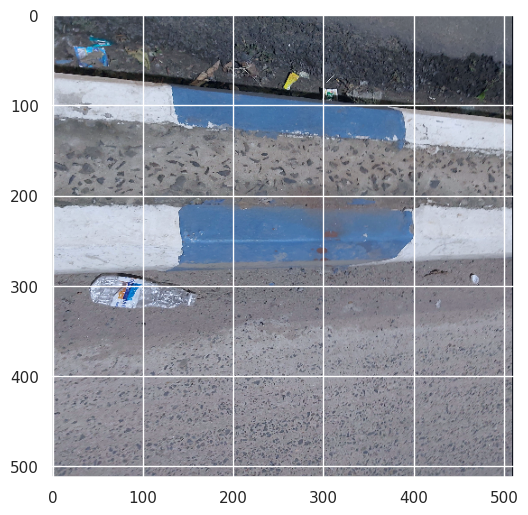

In [59]:
plt.imshow(img.permute(1,2,0))

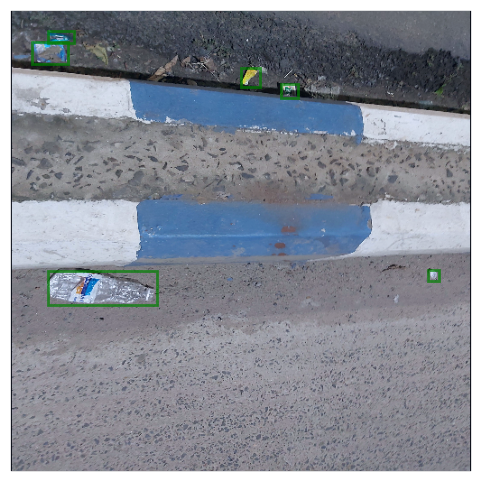

In [60]:
fig,ax = plt.subplots(1)

plt.imshow(img.permute(1,2,0))
plt.xticks([])
plt.yticks([])

# Show annotations
for ann in bboxes[k]:
    [x, y, x1, y1] = ann
    rect = Rectangle((x,y),x1,y1,linewidth=2,edgecolor='green',
                     facecolor='none', alpha=0.7)
    ax.add_patch(rect)
#plt.savefig(f'imgs/output_{img_idx}.png')
plt.show()

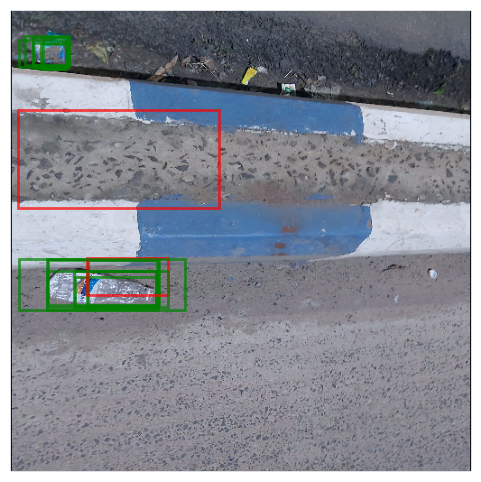

In [61]:
fig,ax = plt.subplots(1)

plt.imshow(img.permute(1,2,0))
plt.xticks([])
plt.yticks([])

# Show annotations
for i, ann in enumerate(proposals_all[0]):
    
    [x, y, x1, y1] = ann
    if predictions_all[i]:
        edge_col = 'green'
    else:
        edge_col = 'red'
    rect = Rectangle((x,y),x1,y1,linewidth=2,edgecolor=edge_col,
                     facecolor='none', alpha=0.7)
    ax.add_patch(rect)
#plt.savefig(f'imgs/output_{img_idx}.png')
plt.show()

In [40]:
data, target = torch.stack(cropped_images_all).to(device), torch.FloatTensor(predictions_all).to(device)
        

In [ ]:
plt.imshow(images[k].permute(1,2,0).detach().cpu().numpy()[y:y+h, x:x+w])

In [ ]:
plt.imshow(fn.crop(, x, y, w, h ))

In [ ]:
target

In [ ]:
plt.imshow(cropped_images_all[1].detach().permute(1,2,0).cpu().numpy())

In [ ]:
target

In [ ]:
test_labels

In [ ]:
plt.imshow(test_data[3].detach().permute(1,2,0).cpu().numpy())

In [ ]:

# CNN
optimizer.zero_grad()
output = model(data)[:,0]
loss = loss_function(output, target)
loss.backward()
optimizer.step()

train_loss.append(loss.item())
predicted = output > 0.5
train_correct += (target==predicted).sum().cpu().item()
train_len += data.shape[0]
print(f'train_loss: {loss:.5f}')
# break
        

In [ ]:
optimizer.zero_grad()
output = model(data)[:,0]
        